In [3]:
## Truncated Gaussian Distribution

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from game.Bankgames import *
from game.plotting import *
from game.distributions import TruncatedGaussian, Uniform, PiecewiseUniform
import nashpy as nh
from tqdm import tqdm

In [2]:
import numpy as np
from itertools import product

def search_eps_signs():
    gamma_values = np.linspace(0.1, 1.0, 10)  # Choosing 5 values for gamma
#     mu_values = np.linspace(0.1, 0.9, 10)  # Mu in [0,1]
#     sigma_values = np.linspace(0.1, 0.9, 10)  # Sigma in [0,1]
    mu_values = [0.1, 0.2, 0.6, 0.8, 0.9]
    sigma_values = [0.2]

    found_cases = {}

    # Iterate over all possible combinations
    for gamma_l, gamma_h, mu, sigma in product(gamma_values, gamma_values, mu_values, sigma_values):
        if gamma_l >= gamma_h:  # Ensure gamma_l < gamma_h
            continue
        
        taus = sorted([1 / (2 + gamma) for gamma in [gamma_l, gamma_h]])
        tg = TruncatedGaussian(mu=mu, sigma=sigma)
        gtm = GameTrueMatrix2by2(gammas=[gamma_l, gamma_h], taus=taus, dist=tg)
        
        eps1, eps2 = gtm.eps1, gtm.eps2
        sign_pair = (np.sign(eps1), np.sign(eps2))

        # Store unique cases for each sign combination
        if sign_pair not in found_cases:
            found_cases[sign_pair] = (gamma_l, gamma_h, mu, sigma, eps1, eps2)

        # Stop early if we found all sign cases
        if len(found_cases) == 4:
            break
    
    # Print results
    for sign_pair, values in found_cases.items():
        gamma_l, gamma_h, mu, sigma, eps1, eps2 = values
        print(f"Sign: {sign_pair}, γ_l: {gamma_l:.2f}, γ_h: {gamma_h:.2f}, μ: {mu:.2f}, σ: {sigma:.2f}, eps1: {eps1:.4f}, eps2: {eps2:.4f}")

# Run the search
search_eps_signs()

Sign: (np.float64(-1.0), np.float64(-1.0)), γ_l: 0.10, γ_h: 0.20, μ: 0.10, σ: 0.20, eps1: -0.0022, eps2: -0.0033
Sign: (np.float64(1.0), np.float64(-1.0)), γ_l: 0.10, γ_h: 0.40, μ: 0.10, σ: 0.20, eps1: 0.0013, eps2: -0.0010
Sign: (np.float64(1.0), np.float64(1.0)), γ_l: 0.10, γ_h: 0.50, μ: 0.10, σ: 0.20, eps1: 0.0035, eps2: 0.0010


In [18]:
import numpy as np
from itertools import product

gamma_values = np.linspace(0.01, 0.99, 100)  # Choosing 5 values for gamma


def search_eps_signs():
    found_cases = {}
    # Iterate over all possible combinations
    for gamma_l, gamma_h in tqdm(product(gamma_values, gamma_values)):
        if gamma_l >= gamma_h:  # Ensure gamma_l < gamma_h
            continue
        taus = sorted([1 / (2 + gamma) for gamma in [gamma_l, gamma_h]])
        puf = PiecewiseUniform(ga_l = gamma_l, ga_h = gamma_h)
        gtm = GameTrueMatrix2by2(gammas=[gamma_l, gamma_h], taus=taus, dist=puf)
        
        eps1, eps2 = gtm.eps1, gtm.eps2
        sign_pair = (np.sign(eps1), np.sign(eps2))

        # Store unique cases for each sign combination
        if sign_pair not in found_cases:
            found_cases[sign_pair] = (gamma_l, gamma_h, eps1, eps2)

        # Stop early if we found all sign cases
        if len(found_cases) == 4:
            break
    
    # Print results
    for sign_pair, values in found_cases.items():
        gamma_l, gamma_h, eps1, eps2 = values
        print(f"Sign: {sign_pair}, γ_l: {gamma_l:.2f}, γ_h: {gamma_h:.2f}, eps1: {eps1:.4f}, eps2: {eps2:.4f}")

# Run the search
search_eps_signs()

10000it [01:24, 118.73it/s]

Sign: (np.float64(-1.0), np.float64(-1.0)), γ_l: 0.01, γ_h: 0.02, eps1: -0.0110, eps2: -0.0100
Sign: (np.float64(-1.0), np.float64(1.0)), γ_l: 0.01, γ_h: 0.07, eps1: -0.0043, eps2: 0.0017
Sign: (np.float64(1.0), np.float64(1.0)), γ_l: 0.01, γ_h: 0.11, eps1: 0.0011, eps2: 0.0110


In [7]:
# constructed to find the fourth case epsilon_1<0 and epsilon_2 >0
gammas = sorted([0.3, 0.5])
taus = sorted([1/(2+gamma) for gamma in gammas])
puf = PiecewiseUniform(ga_l = gammas[0], ga_h = gammas[1]) #needs exactly these gamma_l and high values
gtm = GameTrueMatrix2by2(gammas=[gamma_l, gamma_h], taus=taus, dist=puf)

gtm.eps1,gtm.eps2

(0.0227956515134468, 0.061516304347826185)

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_game_probability_single(game_result, figsize=(12, 5)):
    """
    Plots the probability evolution of actions for Bank 1 and Bank 2.

    Parameters:
    - game_result (tuple): A single tuple containing (p_b1, p_b2, gammas, taus).
    - figsize (tuple): Size of the figure.
    """
    # Unpack the game result
    p_b1, p_b2, gammas, taus = game_result
    
    # Ensure gammas and taus have the same length
    n = len(gammas)
    assert len(taus) == n, "Number of gammas and taus must be equal"

    T, num_actions = p_b1.shape  # Number of time steps and actions
    assert num_actions == n * n, "Mismatch between number of actions and (tau, gamma) pairs"

    time_steps = np.arange(T)  # Time steps
    color_map = plt.cm.hsv
    colors = [color_map(i / num_actions) for i in range(num_actions)]  # Assign distinct colors

    fig, axes = plt.subplots(1, 2, figsize=figsize)  # Two subplots for Bank 1 & Bank 2

    for i, (bank_pw, title, ax) in enumerate(zip([p_b1, p_b2], ["Bank 1", "Bank 2"], axes)):
        for action in range(num_actions):
            tau_idx = action // n
            gamma_idx = action % n
            tau = taus[tau_idx]
            gamma = gammas[gamma_idx]

            # Plot probability evolution
            line, = ax.plot(time_steps, bank_pw[:, action], 
                            color=colors[action], 
                            label=f'(τ={tau:.2f}, γ={gamma:.2f})',
                            linewidth=2)
            
#             # Annotate actions that have significant probability at the final time step
#             if bank_pw[-1, action] >= 0.1:
#                 ax.text(time_steps[-1], bank_pw[-1, action], 
#                         f'τ={tau:.2f}\nγ={gamma:.2f}', 
#                         color=line.get_color(), 
#                         fontweight='bold',
#                         horizontalalignment='left',
#                         verticalalignment='center')

        # Customize plot
        ax.set_title(f'{title} Action Probabilities Over Time')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Probability')
        ax.set_ylim(0, 1)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# PLOTS TODO n = 4 actions BELOW

1) Known Matrix, Full matrix known


Game with n = 4 actions (2 gammas) 
4 cases for epsilon_1, epsilon_2

Dynamics curves, show indifferent to initialization 

- epsilon_1>0, epsilon_2>0 ; 1 pure NE
- epsilon_1<0, epsilon_2<0 1 pure NE
- 3 cases for different signs (-,+)
- 3 cases for different signs (+, -)

---

1) Sampled Matrix (Fresh matrix estimated in each round) 

Game with n = 4 actions (2 gammas)
4 cases for epsilon_1, epsilon_2

Dynamics curves, show indifferent to initialization 

- 1 pure NE
- 1 pure NE
- 3 cases for different signs (-,+)
- 3 cases for different signs (+,-)
 
Fraction of convergence plots
- Fix distribution, fix gamma (defines an instance of the one-shot game)
- For a fixed initilaization, check convergence across randomness in sampling (fresh estimate for A)
- Fix distribution, fix gamma, for some fixed initilaization, check distance to NE across randomness in sampling (fresh estimate for A)


- For a fixed initilaization, check convergence check convergence across randomness in sampling (moving estimate for A)
- Fix distribution, fix gamma, for some fixed initilaization, check distance to NE across randomness in sampling (moving estimate for A)

# PLOTS TODO for larger number of actions

vary distribution (fix truncated gaussian some values)
precified values of gamma
vary initializations

## Case 1 : epsilon_1 > 0, epsilon_2 < 0, 
## 3 NE - 2 pure, 1 mixed

# Using truncgauss here

Three types of hedge dynamics curves
1) hedge on known matrix
2) hedge on fresh sampled each time
3) hedge on moving average

In [69]:
gammas = sorted([0.1, 0.8])
taus = sorted([1/(2+gamma) for gamma in gammas])
mu = 0.6
sigma = 0.2
tg = TruncatedGaussian(mu = mu, sigma = sigma)
gtm = GameTrueMatrix2by2(gammas=gammas, taus=taus, dist=tg)
print(gtm.eps1, gtm.eps2) # epsilon1 and epsilon2

0.03311695444624768 -0.12479184642812025


In [71]:
len(gtm.NE_theory), gtm.NE_theory

(3,
 [[[0, 0, 1, 0], [0, 0, 1, 0]],
  [[0, 1, 0, 0], [0, 1, 0, 0]],
  [[0, 0.7902779689107038, 0.2097220310892962, 0],
   [0, 0.7902779689107038, 0.2097220310892962, 0]]])

In [72]:
# run hedge on known matrix
T = 5000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gtm.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l

[0.00000000e+00 1.00988273e-27 1.00000000e+00 0.00000000e+00] [0.00000000e+00 7.89645439e-28 1.00000000e+00 0.00000000e+00]


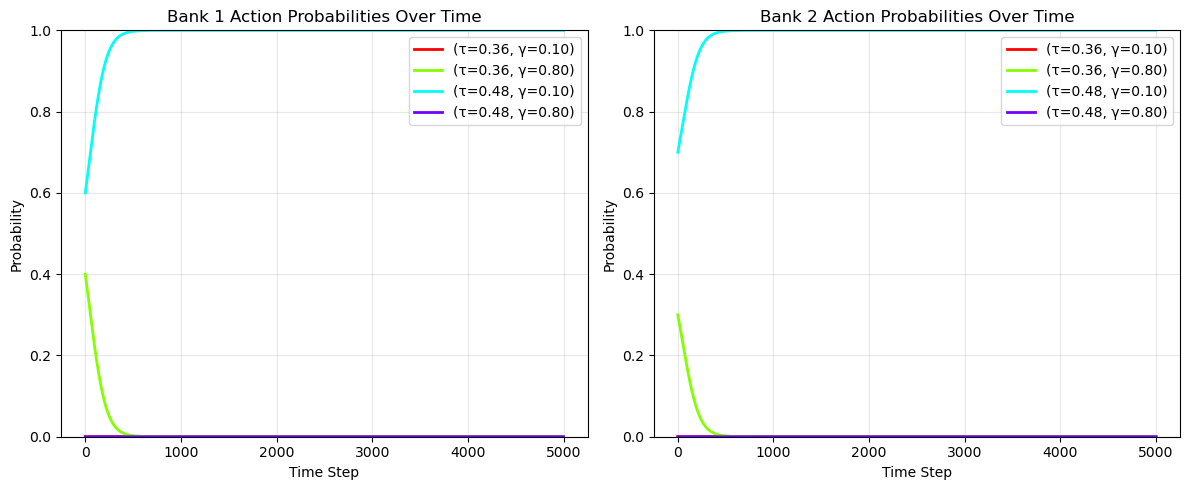

In [73]:
plot_game_probability_single((b1,b2,gammas,taus))

In [74]:
gfe = GameFreshEstimate(gammas=gammas, taus=taus, dist=tg, num_samples=1)

# run hedge on known matrix
T = 5000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gfe.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l

[0.00000000e+00 7.32643069e-28 1.00000000e+00 0.00000000e+00] [0.00000000e+00 5.73681078e-28 1.00000000e+00 0.00000000e+00]


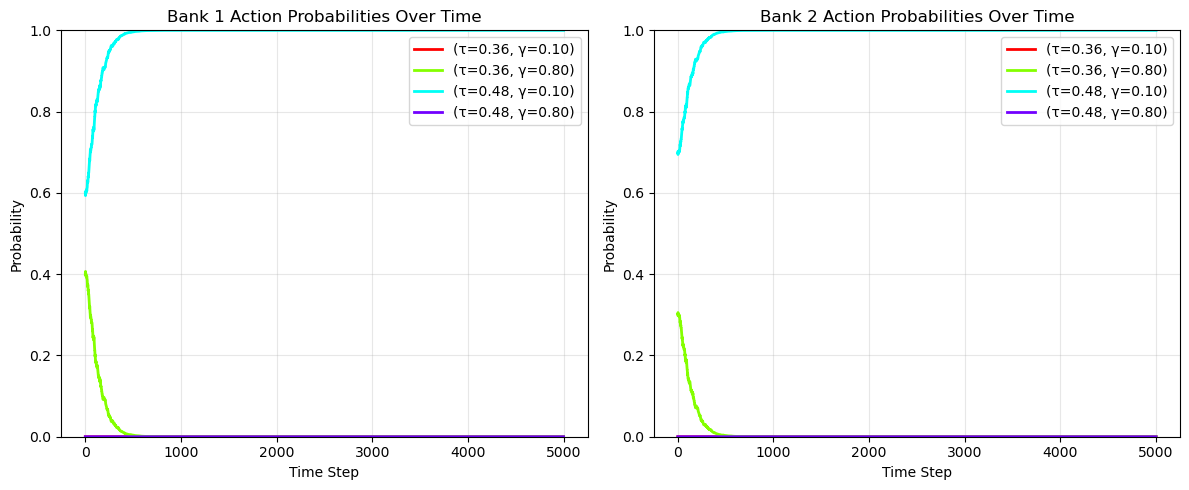

In [75]:
plot_game_probability_single((b1,b2,gammas,taus)) # also goes to the same pure symmetric NE, a bit noisy

In [76]:
gma = GameMovingAvg(gammas=gammas, taus=taus, dist=tg, num_samples=1)

# run hedge on known matrix
T = 5000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gma.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l

[0.00000000e+00 6.62269334e-29 1.00000000e+00 0.00000000e+00] [0.0000000e+00 5.2476592e-29 1.0000000e+00 0.0000000e+00]


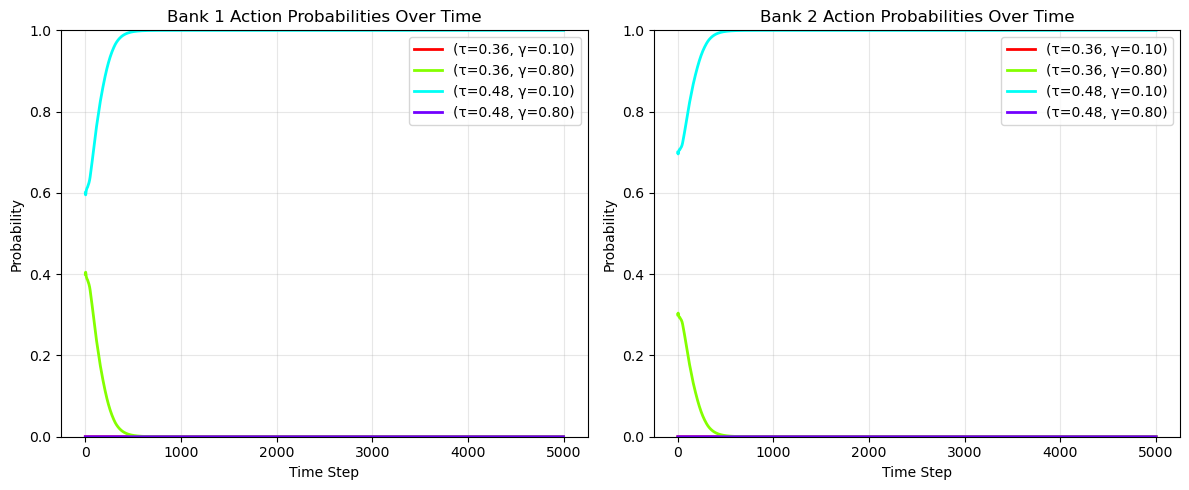

In [77]:
plot_game_probability_single((b1,b2,gammas,taus)) # also goes to the same pure symmetric NE, more smooth

## Case 2 : epsilon_1 < 0, epsilon_2 > 0, 
## 3 NE - 2 pure, 1 mixed

## Using uniform here

In [133]:
gammas = sorted([0.5, 0.6])
taus = sorted([1/(2+gamma) for gamma in gammas])
puf = PiecewiseUniform(ga_l = gammas[0], ga_h = gammas[1]) #needs exactly these gamma_l and high values
gtm = GameTrueMatrix2by2(gammas=gammas, taus=taus, dist=puf)

gtm.eps1,gtm.eps2

(-0.007160000000000114, 0.0006250000000000179)

In [137]:
len(gtm.NE_theory), gtm.NE_theory

(3,
 [[[0, 1, 0, 0], [0, 0, 1, 0]],
  [[0, 0, 1, 0], [0, 1, 0, 0]],
  [[0, 0.08028259473346401, 0.919717405266536, 0],
   [0, 0.08028259473346401, 0.919717405266536, 0]]])

In [138]:
# run hedge on known matrix
T = 100000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gtm.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1])  # WE GO TO MIXED NASH, finally
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l

[0.         0.98709414 0.01290586 0.        ] [0.00000000e+00 9.85227168e-22 1.00000000e+00 0.00000000e+00]


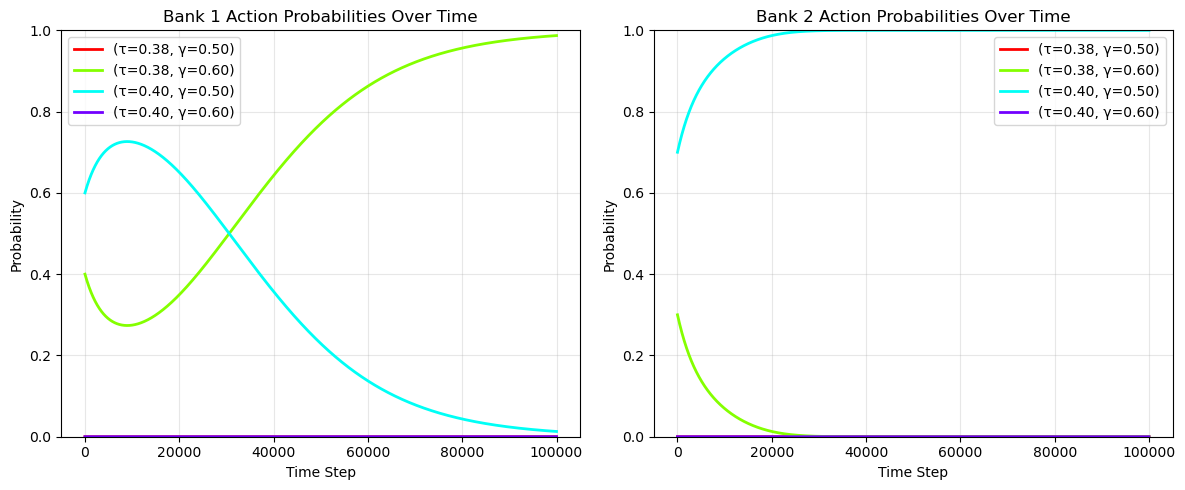

In [139]:
plot_game_probability_single((b1,b2,gammas,taus))

In [142]:
gfe = GameFreshEstimate(gammas=gammas, taus=taus, dist=puf, num_samples=1)

T = 100000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gfe.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l

[0.00000000e+00 1.00000000e+00 2.42212219e-42 0.00000000e+00] [0.0000000e+00 1.0000000e+00 5.0930092e-42 0.0000000e+00]


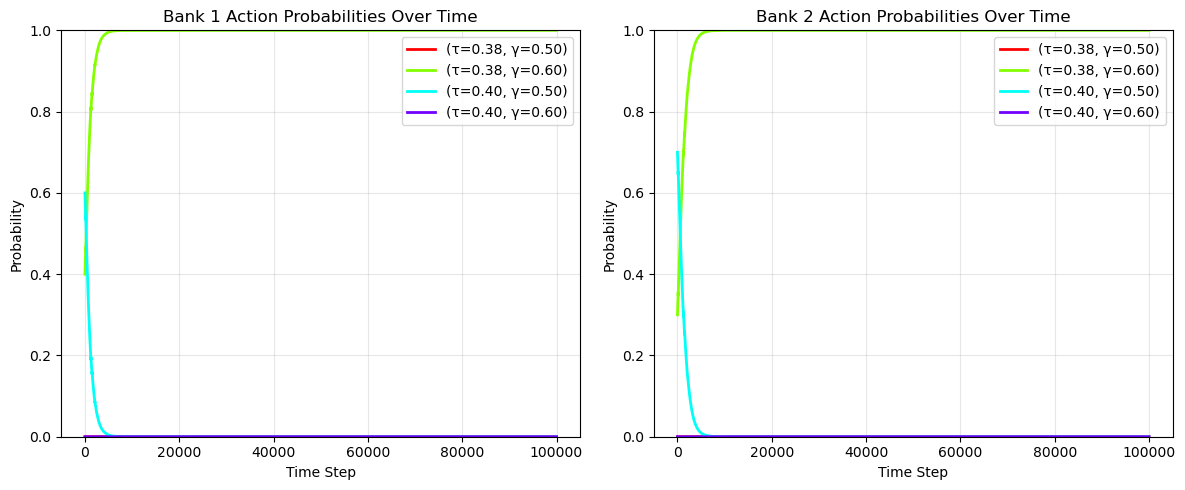

In [143]:
plot_game_probability_single((b1,b2,gammas,taus))

In [144]:
gfe = GameMovingAvg(gammas=gammas, taus=taus, dist=puf, num_samples=1)

T = 100000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gfe.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l

[0.00000000e+00 1.00000000e+00 2.04412984e-42 0.00000000e+00] [0.00000000e+00 1.00000000e+00 4.25959241e-42 0.00000000e+00]


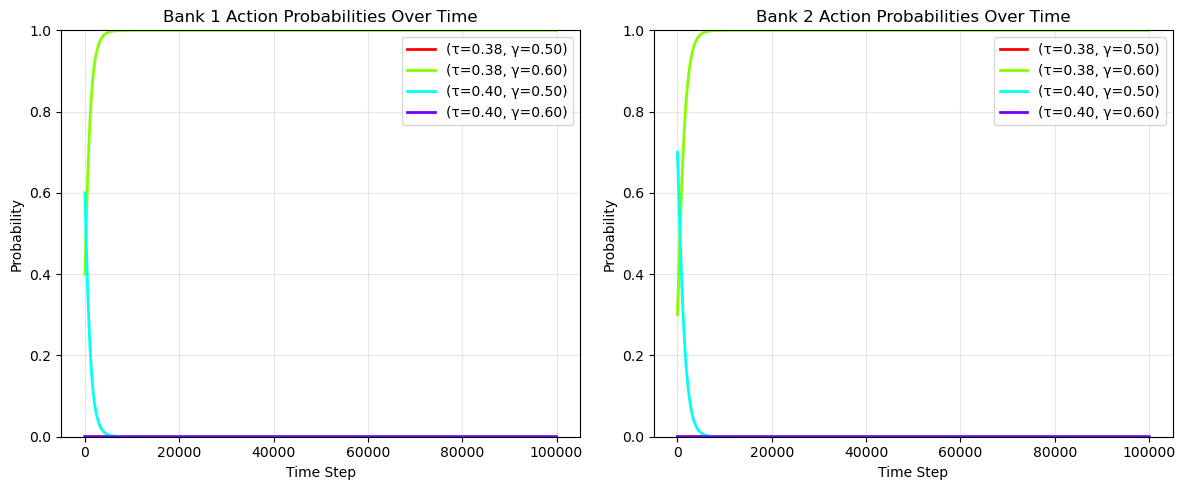

In [145]:
plot_game_probability_single((b1,b2,gammas,taus))

## Case 3: epsilon_1 < 0, epsilon_2 < 0

## Single Pure NE, symmetric (tau_h, gamma_l)

# using trungauss here

In [78]:
gammas = sorted([0.4, 0.8])
taus = sorted([1/(2+gamma) for gamma in gammas])
mu = 0.6
sigma = 0.2
tg = TruncatedGaussian(mu = mu, sigma = sigma)
gtm = GameTrueMatrix2by2(gammas=gammas, taus=taus, dist=tg)
print(gtm.eps1, gtm.eps2) # epsilon1<0 and epsilon2<0

-0.12134951137879568 -0.22492712153259348


In [79]:
len(gtm.NE_theory), gtm.NE_theory

(1, [[[0, 0, 1, 0], [0, 0, 1, 0]]])

In [80]:
# run hedge on known matrix
T = 5000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gtm.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l

[0.00000000e+00 1.15321507e-49 1.00000000e+00 0.00000000e+00] [0.00000000e+00 7.96310351e-50 1.00000000e+00 0.00000000e+00]


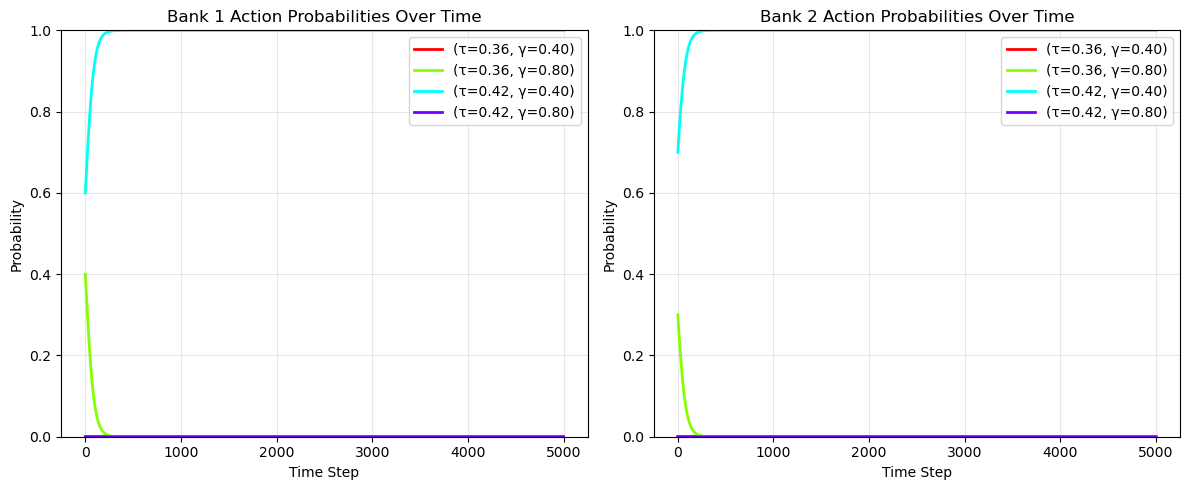

In [81]:
plot_game_probability_single((b1,b2,gammas,taus))

In [82]:
gfe = GameFreshEstimate(gammas=gammas, taus=taus, dist=tg, num_samples=1)

# run hedge on known matrix
T = 5000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gfe.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l

[0.00000000e+00 5.62749515e-49 1.00000000e+00 0.00000000e+00] [0.00000000e+00 3.90815513e-49 1.00000000e+00 0.00000000e+00]


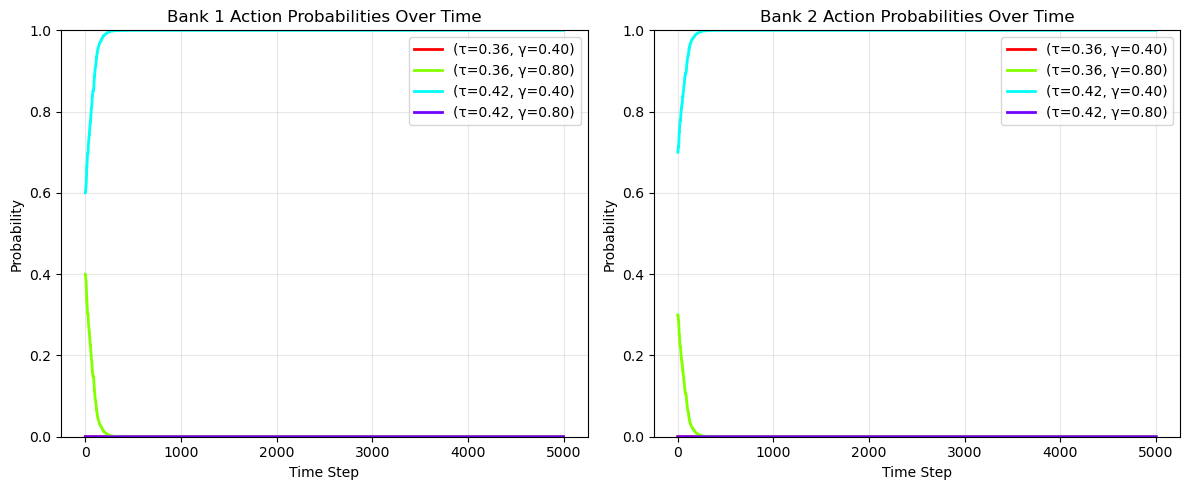

In [83]:
plot_game_probability_single((b1,b2,gammas,taus))

In [84]:
gma = GameMovingAvg(gammas=gammas, taus=taus, dist=tg, num_samples=1)

# run hedge on known matrix
T = 5000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gma.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l

[0.0000000e+00 1.9935659e-49 1.0000000e+00 0.0000000e+00] [0.00000000e+00 1.38199753e-49 1.00000000e+00 0.00000000e+00]


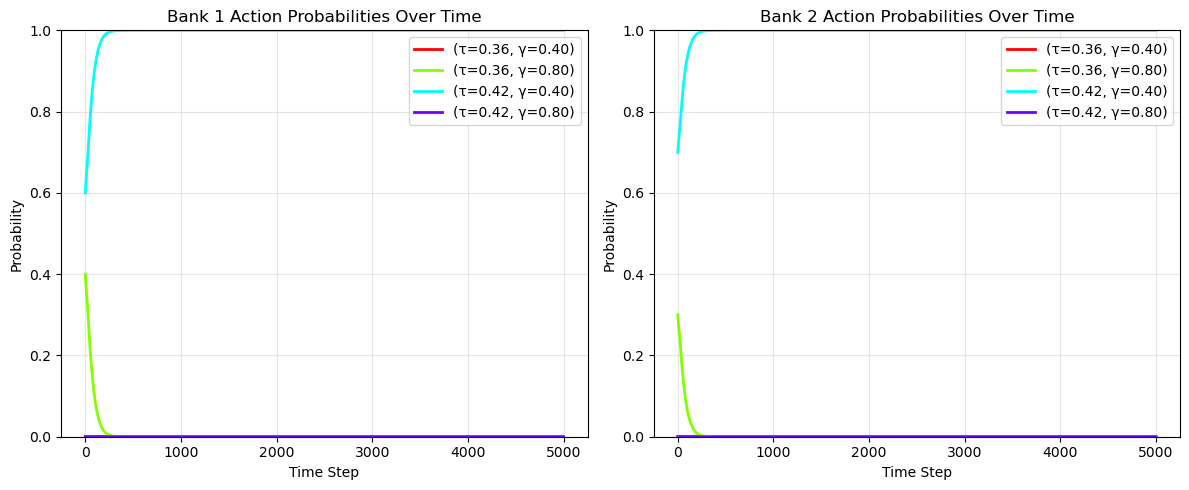

In [85]:
plot_game_probability_single((b1,b2,gammas,taus))

## Case 4: epsilon_1 > 0, epsilon_2 > 0

## Single Pure NE, symmetric (tau_l, gamma_h)

# using piewise uniform here

In [ ]:
# Sign: (np.float64(-1.0), np.float64(-1.0)), γ_l: 0.01, γ_h: 0.02, eps1: -0.0110, eps2: -0.0100
# Sign: (np.float64(-1.0), np.float64(1.0)), γ_l: 0.01, γ_h: 0.07, eps1: -0.0043, eps2: 0.0017
# Sign: (np.float64(1.0), np.float64(1.0)), γ_l: 0.01, γ_h: 0.11, eps1: 0.0011, eps2: 0.0110

In [86]:
gammas = sorted([0.3, 0.5])
taus = sorted([1/(2+gamma) for gamma in gammas])
puf = PiecewiseUniform(ga_l = gammas[0], ga_h = gammas[1]) #needs exactly these gamma_l and high values
gtm = GameTrueMatrix2by2(gammas=[gamma_l, gamma_h], taus=taus, dist=puf)

gtm.eps1,gtm.eps2

(0.0227956515134468, 0.061516304347826185)

In [87]:
len(gtm.NE_se), gtm.NE_se # 1 pure NE only in the one shot game
gtm.NE_theory

[[[0, 1, 0, 0], [0, 1, 0, 0]]]

In [88]:
# run hedge on known matrix
T = 5000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gtm.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l

[0.00000000e+00 9.99995844e-01 4.15578960e-06 0.00000000e+00] [0.00000000e+00 9.99989463e-01 1.05374315e-05 0.00000000e+00]


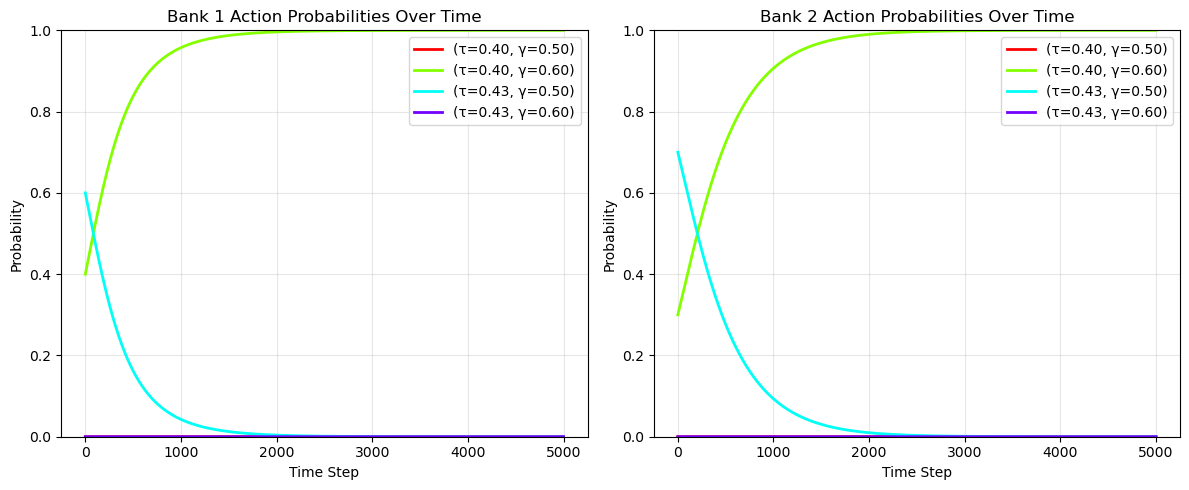

In [51]:
plot_game_probability_single((b1,b2,gammas,taus))

In [89]:
gfe = GameFreshEstimate(gammas=gammas, taus=taus, dist=puf, num_samples=1)

# run hedge on known matrix
T = 5000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gfe.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l

[0.00000000e+00 1.00000000e+00 4.68570237e-10 0.00000000e+00] [0.00000000e+00 9.99999999e-01 9.75994940e-10 0.00000000e+00]


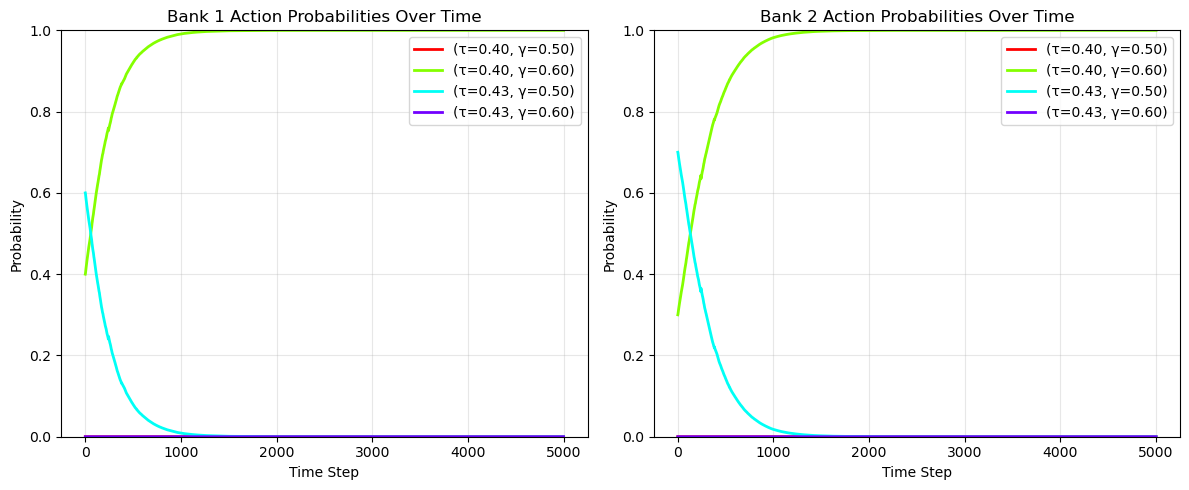

In [90]:
plot_game_probability_single((b1,b2,gammas,taus))

In [91]:
gma = GameMovingAvg(gammas=gammas, taus=taus, dist=puf, num_samples=1)

# run hedge on known matrix
T = 5000
eta = 0.1
p_b1 = np.array([0., 0.1, 0.9, 0.])
p_b2 = np.array([0., 0.5, 0.3, 0.])

b1,b2,gammas,taus = gma.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l

[0.00000000e+00 9.99999992e-01 7.91326273e-09 0.00000000e+00] [0.00000000e+00 1.00000000e+00 7.97706544e-11 0.00000000e+00]


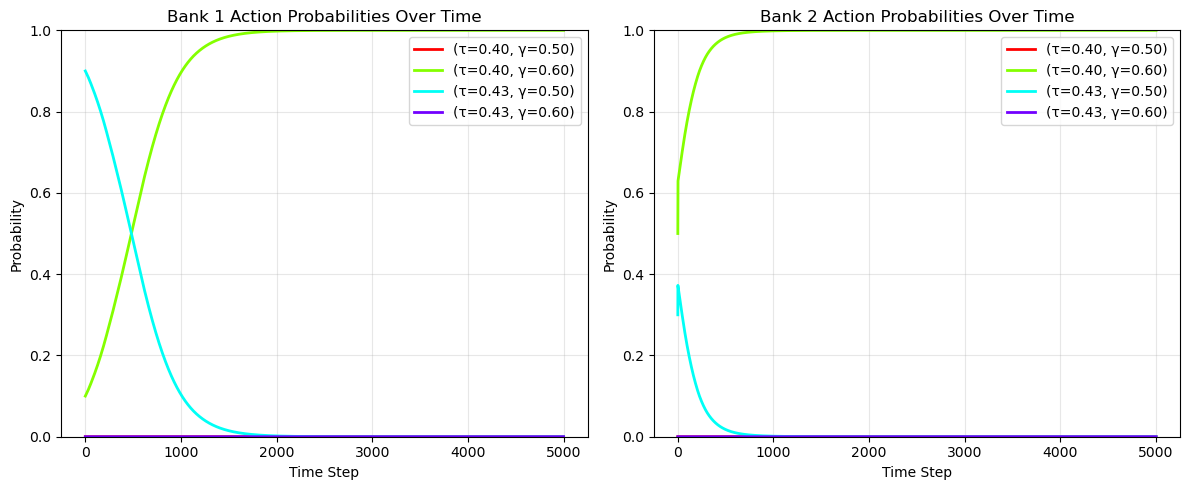

In [92]:
plot_game_probability_single((b1,b2,gammas,taus))